In [1]:
import xarray as xr
import numpy as np
from PIL import Image as PILImage
from osgeo import gdal, osr, gdal_array
import netCDF4
url = 'cloud3D_image.nc'
nc = netCDF4.Dataset(url)
data = nc.variables
print (data.keys())

[u'band_0', u'nb_views', u'nodata', u'radius', u'secondary_1', u'secondary_2', u'dir_view_1_vector', u'dir_view_1_origin', u'dir_view_2_vector', u'dir_view_2_origin', u'dir_view_3_vector', u'dir_view_3_origin', u'coord_ECEF']


In [2]:
data

OrderedDict([(u'band_0', <type 'netCDF4._netCDF4.Variable'>
              int32 band_0(i, j)
              unlimited dimensions: 
              current shape = (500, 500)
              filling on, default _FillValue of -2147483647 used),
             (u'nb_views', <type 'netCDF4._netCDF4.Variable'>
              int32 nb_views(i, j)
              unlimited dimensions: 
              current shape = (500, 500)
              filling on, default _FillValue of -2147483647 used),
             (u'nodata', <type 'netCDF4._netCDF4.Variable'>
              int32 nodata(i, j)
              unlimited dimensions: 
              current shape = (500, 500)
              filling on, default _FillValue of -2147483647 used),
             (u'radius', <type 'netCDF4._netCDF4.Variable'>
              float32 radius(i, j)
              unlimited dimensions: 
              current shape = (500, 500)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'secondary_1', <type 

In [3]:
cloud3D = np.array(nc.variables['coord_ECEF'])
print (np.shape(cloud3D))

(3, 500, 500)


On récupère la position (x,y,z) pour chaque point de l'image:

In [7]:
cloud_check = cloud3D[:10,:10]
print (cloud_check == 0)

[[[False False False ... False False False]
  [ True False False ... False False False]
  [ True False False ... False False False]
  ...
  [False False  True ... False False False]
  [False False  True ... False False False]
  [False  True False ... False False False]]

 [[False False False ... False False False]
  [ True False False ... False False False]
  [ True False False ... False False False]
  ...
  [False False  True ... False False False]
  [False False  True ... False False False]
  [False  True False ... False False False]]

 [[False False False ... False False False]
  [ True False False ... False False False]
  [ True False False ... False False False]
  ...
  [False False  True ... False False False]
  [False False  True ... False False False]
  [False  True False ... False False False]]]


On utilise des classes par l'algorithme  Kmeans par défaut de OTB

In [7]:
classe = gdal.Open('clLabeledImage_SVM.tif')
band = classe.GetRasterBand(1)
arr = band.ReadAsArray()
print (arr)
print (np.shape(arr))
print ("nombre de classe est égale à " + str(np.max(arr)-np.min(arr)+1))

[[2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(650, 650)
nombre de classe est égale à 3


Ici, pour chaque pixel de l'image, on a sa position 3D et sa classe. 

In [23]:
classe = gdal.Open('ExtractROI_IMG1.tif')
band = classe.GetRasterBand(1)
print (band)
arr = band.ReadAsArray()
print (arr)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f216f2cd060> >
[[1354. 1239.  960. ...  685.  627.  606.]
 [1352. 1245.  943. ...  828.  765.  696.]
 [1110. 1074.  852. ...  899.  846.  774.]
 ...
 [ 648.  757.  809. ...  449.  450.  446.]
 [ 557.  638.  673. ...  445.  447.  441.]
 [ 501.  525.  537. ...  458.  463.  454.]]


In [24]:
print (np.shape(arr))

(606, 650)


In [8]:
x = np.array(cloud3D[0])
y = np.array(cloud3D[1])
z = np.array(cloud3D[2])

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
print (np.min(y), np.max(y))

(0.0, 2907190.0)


In [49]:
import pyproj

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='utm', ellps='WGS84', datum='WGS84')

p = pyproj.transform(ecef, lla, x, y, z, radians=True)
print (p)

(array([[3364214.86394848, 3364214.19663856, 3364214.19663856, ...,
        3363955.90776735, 3363954.92710709, 3363955.2404199 ],
       [ 500000.        , 3364214.19663856, 3364213.2159803 , ...,
        3363955.90776735, 3363954.92710709, 3363953.94644676],
       [ 500000.        , 3364214.27710044, 3364213.60979038, ...,
        3363955.00757655, 3363954.92710709, 3363953.94644676],
       ...,
       [3364116.3343719 , 3364115.94058708, 3364114.95992804, ...,
        3363857.54146736, 3363856.56080536, 3363856.56080536],
       [3364116.3343719 , 3364115.35371276, 3364115.6670631 , ...,
        3363856.24749018, 3363856.56080536, 3363855.58014328],
       [3364116.3343719 , 3364115.35371276, 3364115.08018859, ...,
        3363856.64124745, 3363856.64124745, 3363855.54041792]]), array([[-15292825.10880031, -15292825.88325235, -15292825.88325235, ...,
        -15292925.04266603, -15292925.00402287, -15292925.81711765],
       [  9997964.943021  , -15292825.88325235, -15292825.84460

In [56]:
lon = p[0]
lat = p[1]
print (np.max(lat), np.min(lat), np.mean(lat))
print (np.max(lon), np.min(lon), np.mean(lon))
arr = np.array(arr)
print (arr[0,1])

(9997964.943020998, -15292925.817117652, -15004736.415633723)
(3364214.863948482, 500000.0, 3331419.646907395)
2


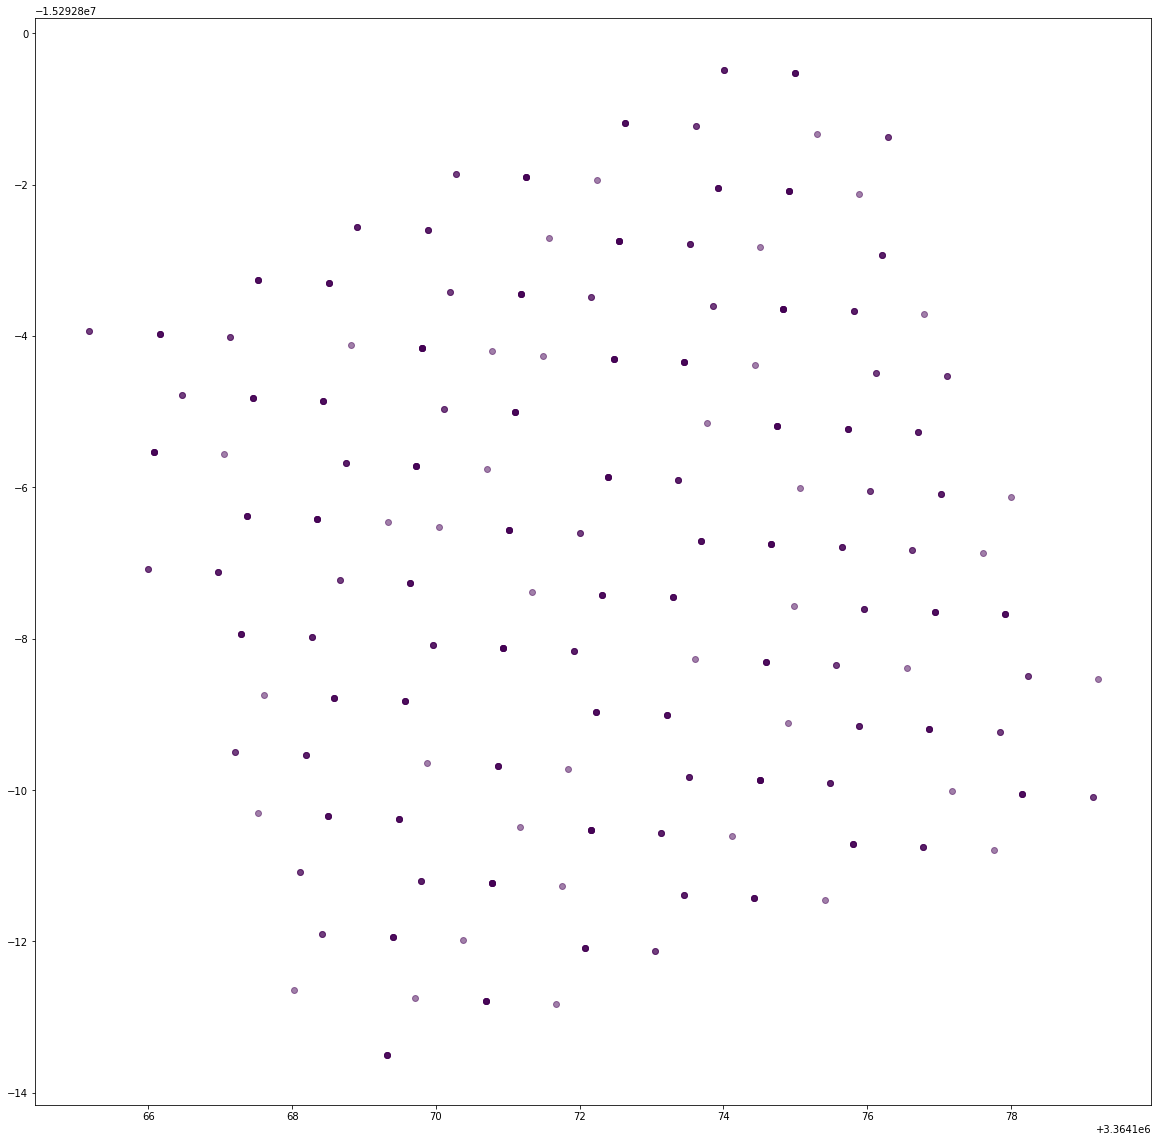

In [65]:
fig = plt.figure(figsize=(20,20))
# delta = 0.00000001
# plt.xlim(np.mean(lon)-delta,np.mean(lon)+delta)
# plt.ylim(np.mean(lat)-delta,np.mean(lat)+delta)
for i in range(50,70):
    for j in range(50,70):
        plt.scatter(lon[i,j], lat[i,j], c = arr[i,j]*10, alpha=0.5)
plt.show()

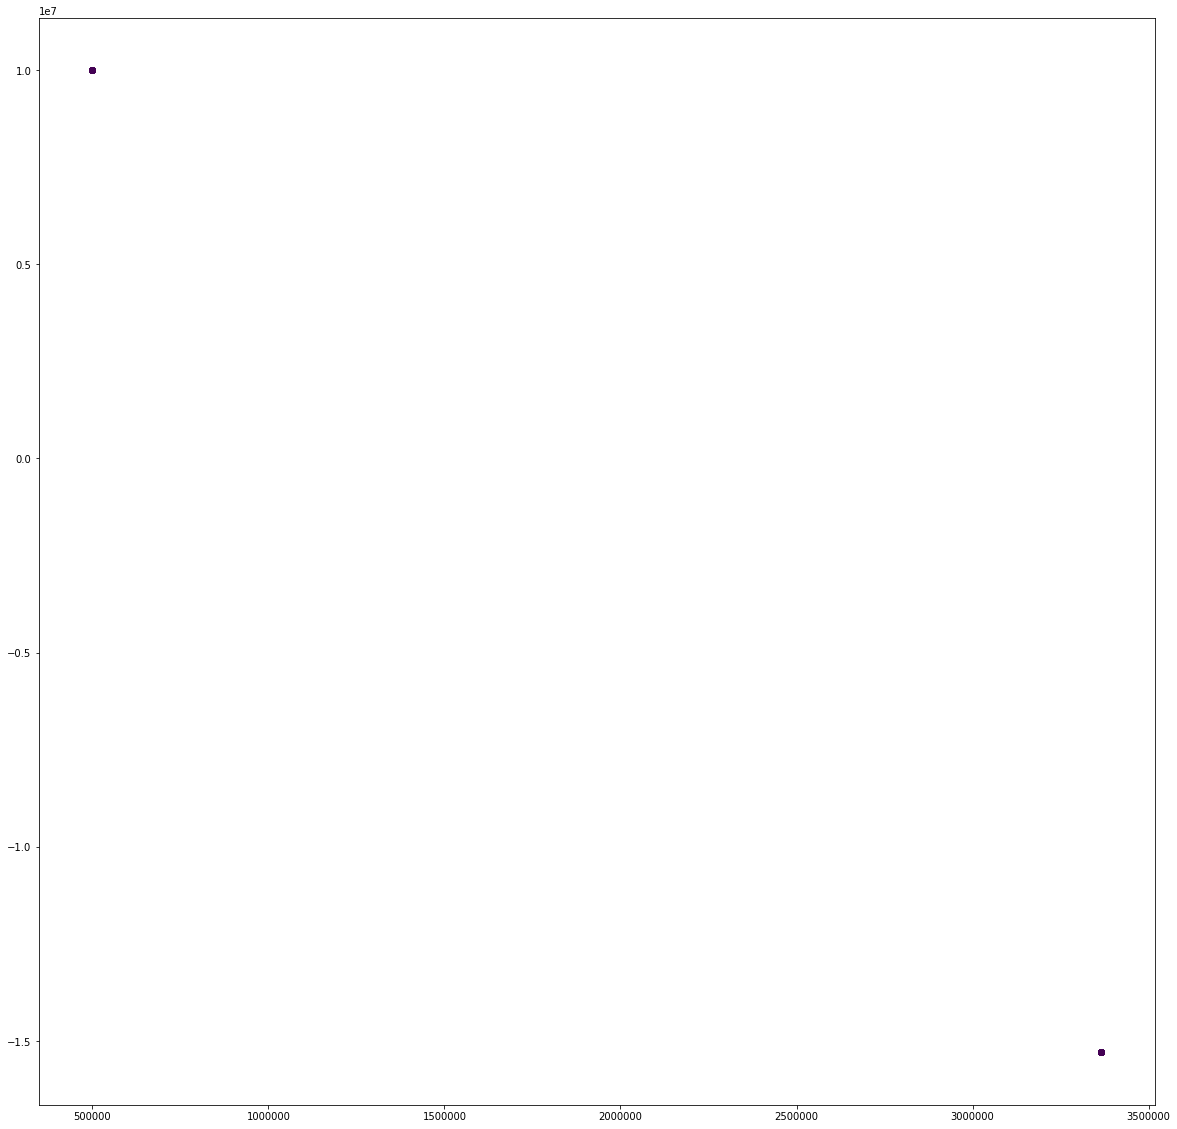

In [66]:
fig = plt.figure(figsize=(20,20))
# delta = 0.00000001
# plt.xlim(np.mean(lon)-delta,np.mean(lon)+delta)
# plt.ylim(np.mean(lat)-delta,np.mean(lat)+delta)
for i in range(50):
    for j in range(50):
        plt.scatter(lon[i,j], lat[i,j], c = arr[i,j]*10, alpha=0.5)
plt.show()

Effectivement, il y a deux groupes de  points 

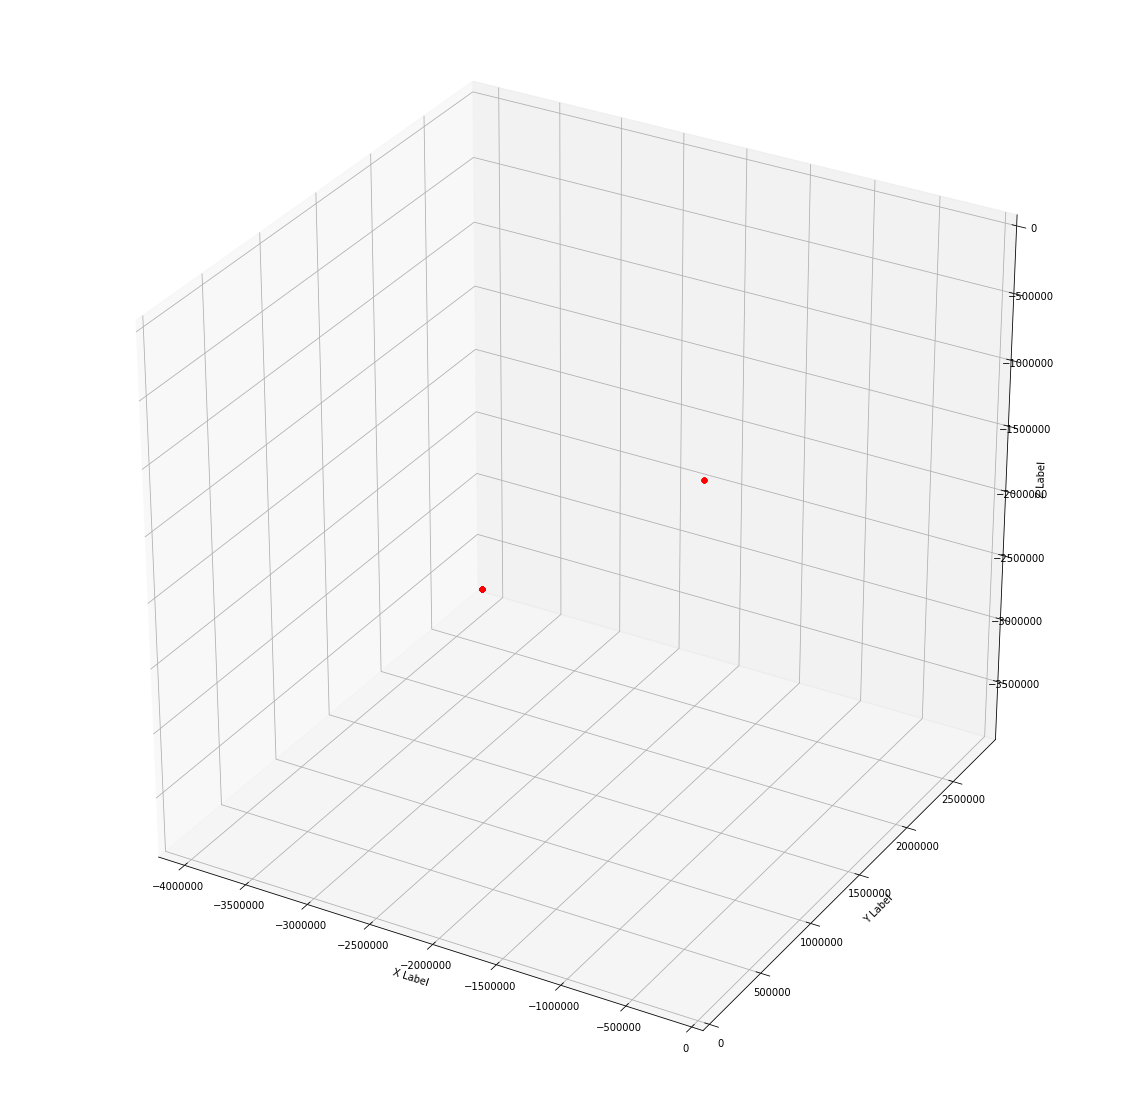

In [18]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(np.min(x), np.max(x))
ax.set_ylim3d(np.min(y), np.max(y))
ax.set_zlim3d(np.min(z), np.max(z))

for i in range(50):
    for j in range(50):
        
        ax.scatter(x[i,j], y[i,j], z[i,j], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()